**1. Importing Data From Kaggle**

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import glob as gb
import cv2
import tensorflow as tf
import keras
import os
from sklearn.metrics import confusion_matrix


**2. Processing the Data**

In [ ]:
train_path = '/content/seg_train/'
test_path = '/content/seg_test/'
pred_path = '/content/seg_pred/'

In [ ]:
def open_folders(path, file, name = 'Traning Data'):
    for folder in os.listdir(path + file):
        files = gb.glob(pathname = path + file + '/' + folder + '/*.jpg')
        print(f'For {name} : Found {len(files)} images in folder {folder}')

print('-' * 40 + ' Traning Data ' + '-' * 46)
open_folders(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
open_folders(test_path, 'seg_test', name = 'Test Data')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
files = gb.glob(pathname = pred_path + 'seg_pred' + '/*.jpg')
print(f'For Prediction Data : Found {len(files)} images in folder Prediction')

---------------------------------------- Traning Data ----------------------------------------------
For Traning Data : Found 2382 images in folder street
For Traning Data : Found 2274 images in folder sea
For Traning Data : Found 2271 images in folder forest
For Traning Data : Found 2404 images in folder glacier
For Traning Data : Found 2512 images in folder mountain
For Traning Data : Found 2191 images in folder buildings

---------------------------------------- Test Data --------------------------------------------------
For Test Data : Found 501 images in folder street
For Test Data : Found 510 images in folder sea
For Test Data : Found 474 images in folder forest
For Test Data : Found 553 images in folder glacier
For Test Data : Found 525 images in folder mountain
For Test Data : Found 437 images in folder buildings

---------------------------------------- Prediction Data --------------------------------------------
For Prediction Data : Found 7301 images in folder Prediction


In [ ]:
# Check Size Of Images
def get_image_size(path, folder_name):
    size = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname = path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = plt.imread(file)
                size.append(image.shape)
    else:
        files = gb.glob(pathname = path + folder_name + '/*.jpg')
        for file in files:
            image = plt.imread(file)
            size.append(image.shape)

    print(pd.Series(size).value_counts())

print('-' * 40 + ' Traning Data ' + '-' * 46)
get_image_size(train_path, 'seg_train')
print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
get_image_size(test_path, 'seg_test')
print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
get_image_size(pred_path, 'seg_pred')


---------------------------------------- Traning Data ----------------------------------------------
(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(142, 150, 3)        2
(144, 150, 3)        2
(146, 150, 3)        2
(134, 150, 3)        2
(123, 150, 3)        2
(143, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(120, 150, 3)        1
(140, 150, 3)        1
(147, 150, 3)        1
(141, 150, 3)        1
(131, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(103, 150, 3)        1
(100, 150, 3)        1
(105, 150, 3)        1
(76, 150, 3)         1
(149, 150, 3)        1
(97, 150, 3)         1
(119, 150, 3)        1
(133, 150, 3)        1
(102, 150, 3)        1
(110, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
Name: count, dtype: int64

---------------------------------------- Test Data --------------------------------------------------
(150, 150, 3)    2993
(141, 150, 3)       1
(72, 150, 3) 

<div style="font-size: 18px; color: #333; padding: 20px; background-color: #f9f9f9; border-left: 5px solid #4A90E2; border-radius: 8px; line-height: 1.6;">
  Most of the images are sized <strong>150x150x3</strong>, and they need to be uniform in size for the model, which only accepts input in one specific dimension. To avoid losing significant information, we will resize them to <strong>100x100x3</strong>.
</div>


**Assignging Labels**

In [ ]:
# Get Image In Arrays And Resize Images
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_name(code_number):
    for key, value in code.items():
        if code_number == value:
            return key

In [ ]:
new_size = 100
def get_image_array(path, folder_name, new_size = new_size):
    X = []
    y = []
    if folder_name != 'seg_pred':
        for folder in os.listdir(path + folder_name):
            files = gb.glob(pathname= path + folder_name + '/' + folder + '/*.jpg')
            for file in files:
                image = cv2.imread(file)
                image_array = cv2.resize(image, (new_size, new_size))
                X.append(list(image_array))
                y.append(code[folder])
    else :
        files = gb.glob(pathname= path + folder_name + '/*.jpg')
        for file in files:
            image = cv2.imread(file)
            image_array = cv2.resize(image, (new_size, new_size))
            X.append(list(image_array))
    return X, y

In [ ]:
X_train, y_train = get_image_array(train_path, 'seg_train')
X_test, y_test = get_image_array(test_path, 'seg_test')
X_pred, _ = get_image_array(pred_path, 'seg_pred')

print('-' * 40 + ' Traning Data ' + '-' * 46)
print(f'We Have {len(X_train)} Image In X_train')
print(f'We Have {len(y_train)} items In y_train ')

print('\n' +'-' * 40 + ' Test Data ' + '-' * 50)
print(f'We Have {len(X_test)} Image In X_test')
print(f'We Have {len(y_test)} items In y_test')

print('\n' +'-' * 40 + ' Prediction Data ' + '-' * 44)
print(f'We Have {len(X_pred)} Image In X_pred')

---------------------------------------- Traning Data ----------------------------------------------
We Have 14034 Image In X_train
We Have 14034 items In y_train 

---------------------------------------- Test Data --------------------------------------------------
We Have 3000 Image In X_test
We Have 3000 items In y_test

---------------------------------------- Prediction Data --------------------------------------------
We Have 7301 Image In X_pred


**Plot Image function to plot some images from each category**

In [ ]:
# Plot Some Picture
def plot_some_image(X, y, name):
    print('-' * 77 + f' {name} Data ' + '-' * 77)
    plt.figure(figsize = (30, 40))
    for n, i in enumerate(list(np.random.randint(0, len(X), 36))):
        plt.subplot(6, 6, n+1)
        plt.imshow(X[i])
        plt.axis('off')
        if name != 'Prediction':
            plt.title(get_name(y[i]), fontdict = {'fontsize': 14, 'color': 'red'})


**Plotting Images from Training Dataset**

----------------------------------------------------------------------------- Traning Data -----------------------------------------------------------------------------


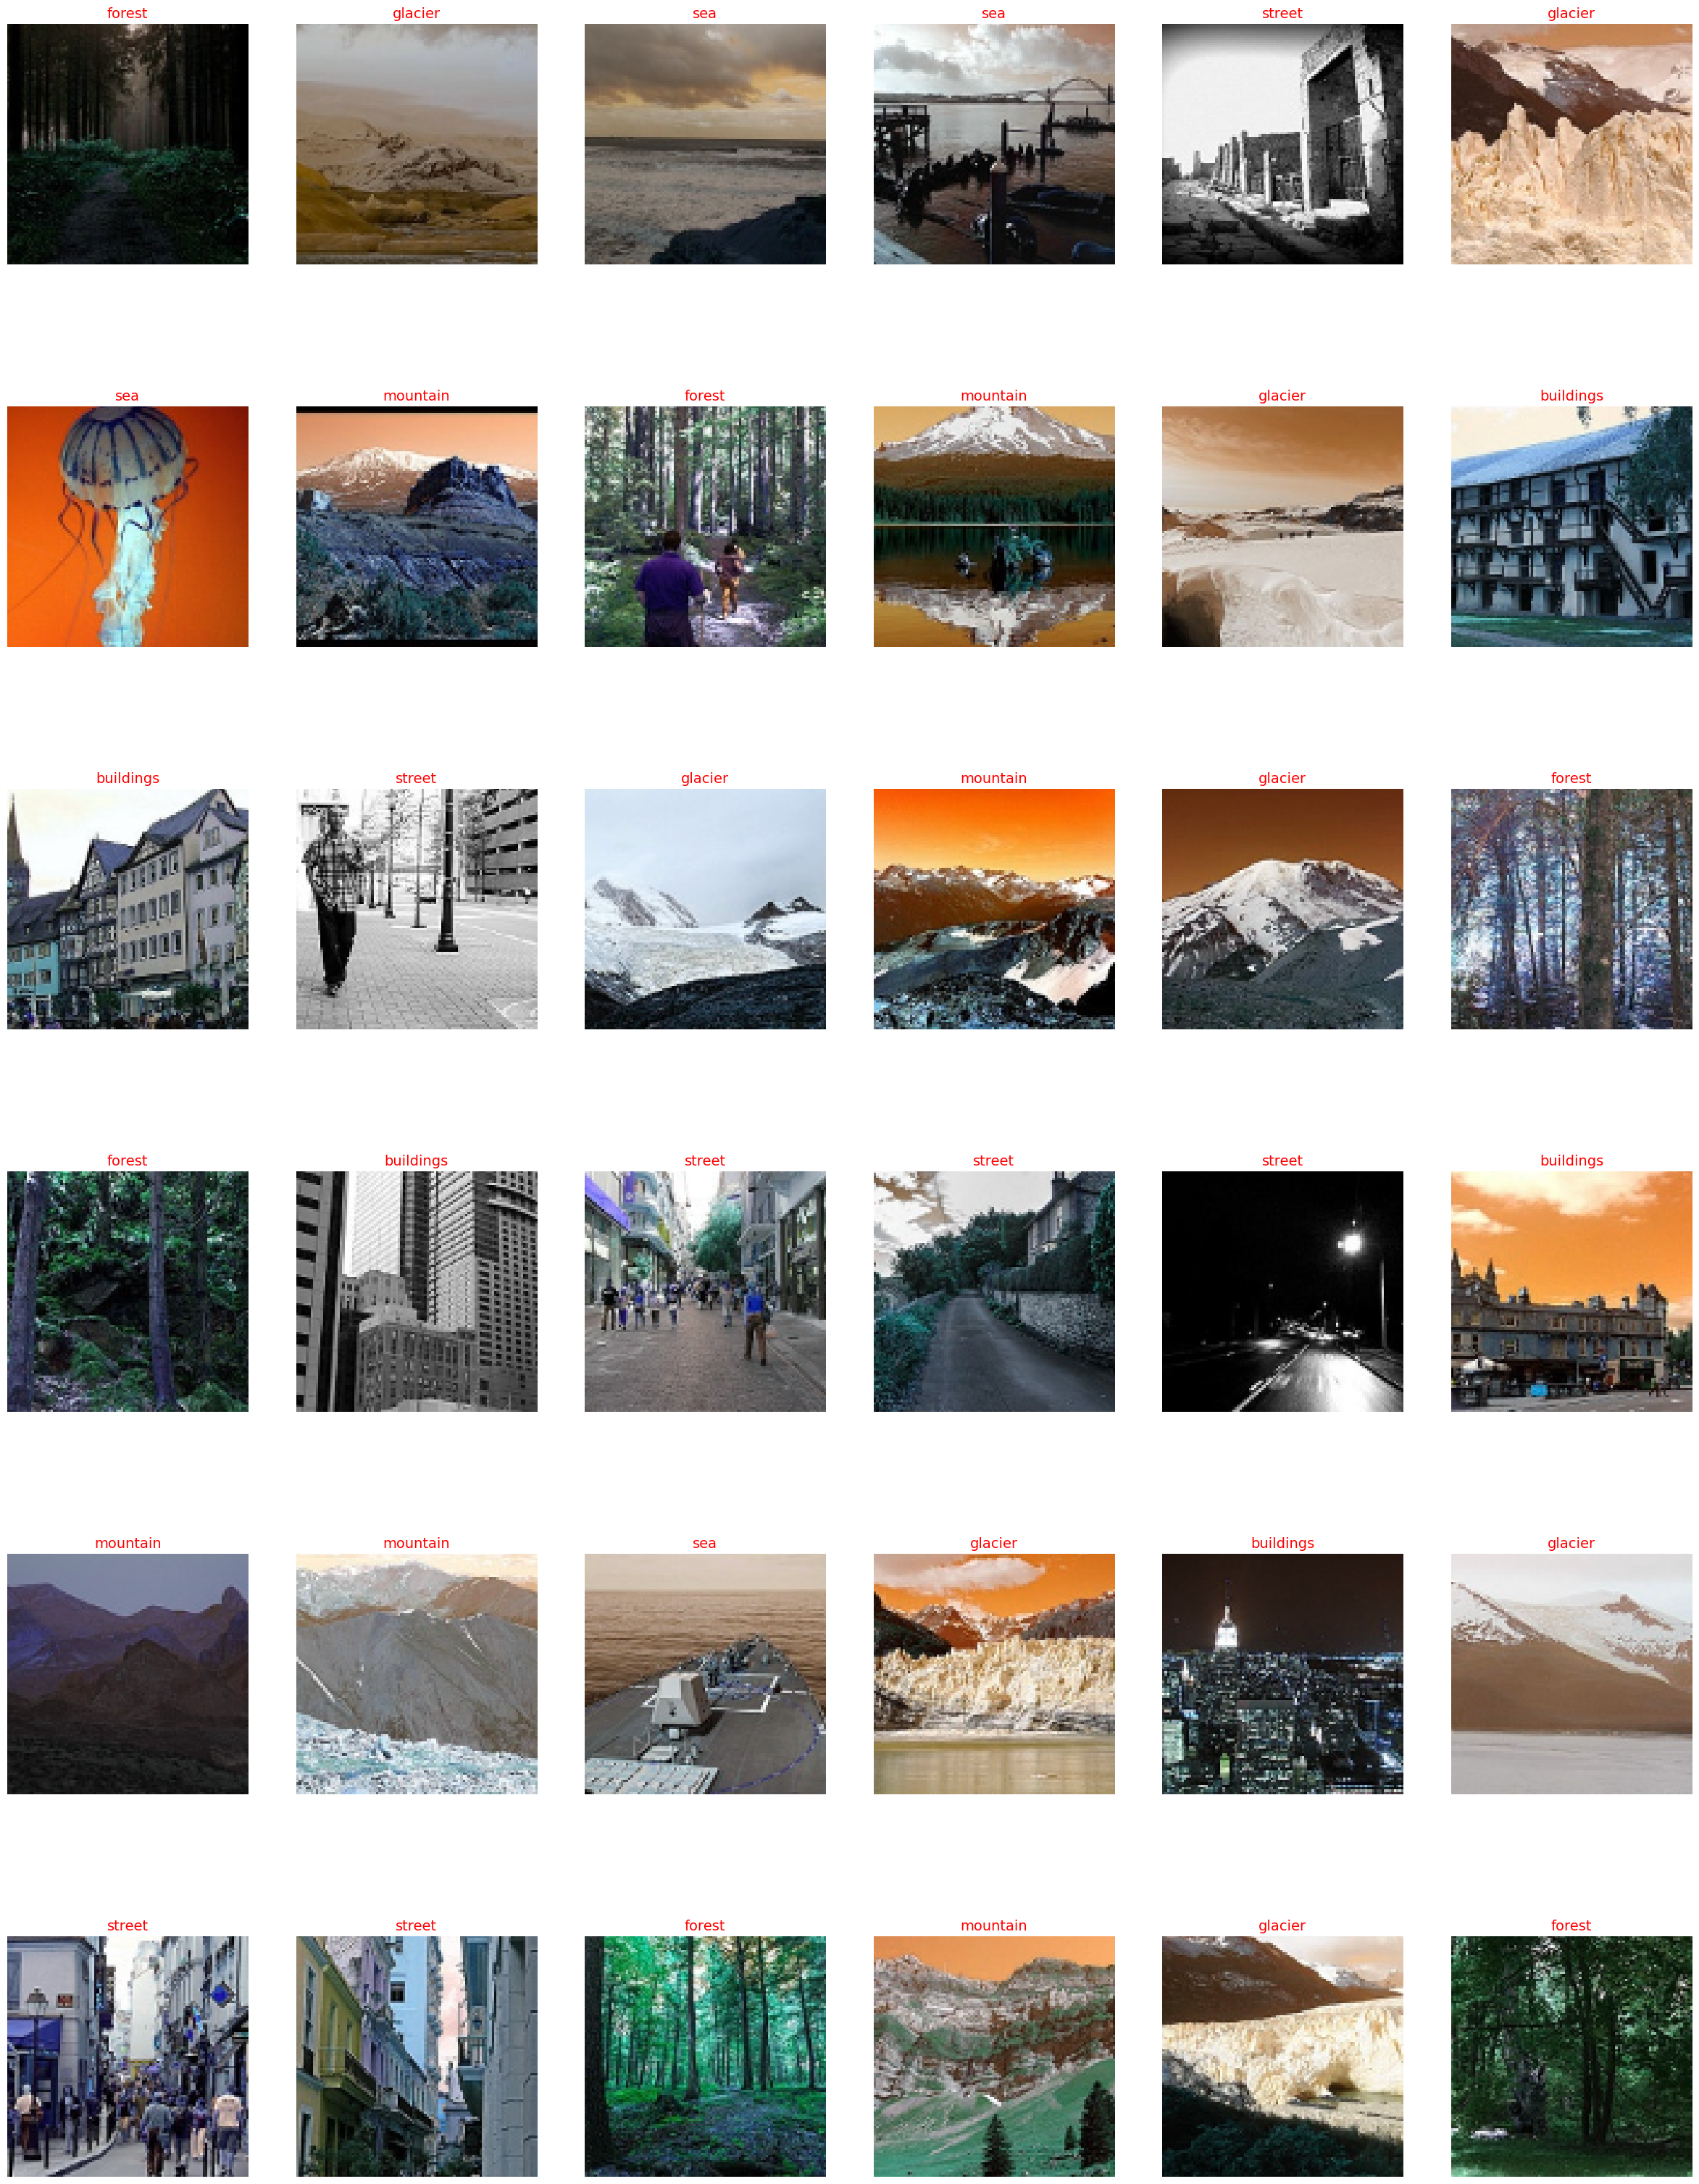

In [ ]:
plot_some_image(X_train, y_train, name = 'Traning')

**Plotting Images from Testing Dataset**

----------------------------------------------------------------------------- Test Data -----------------------------------------------------------------------------


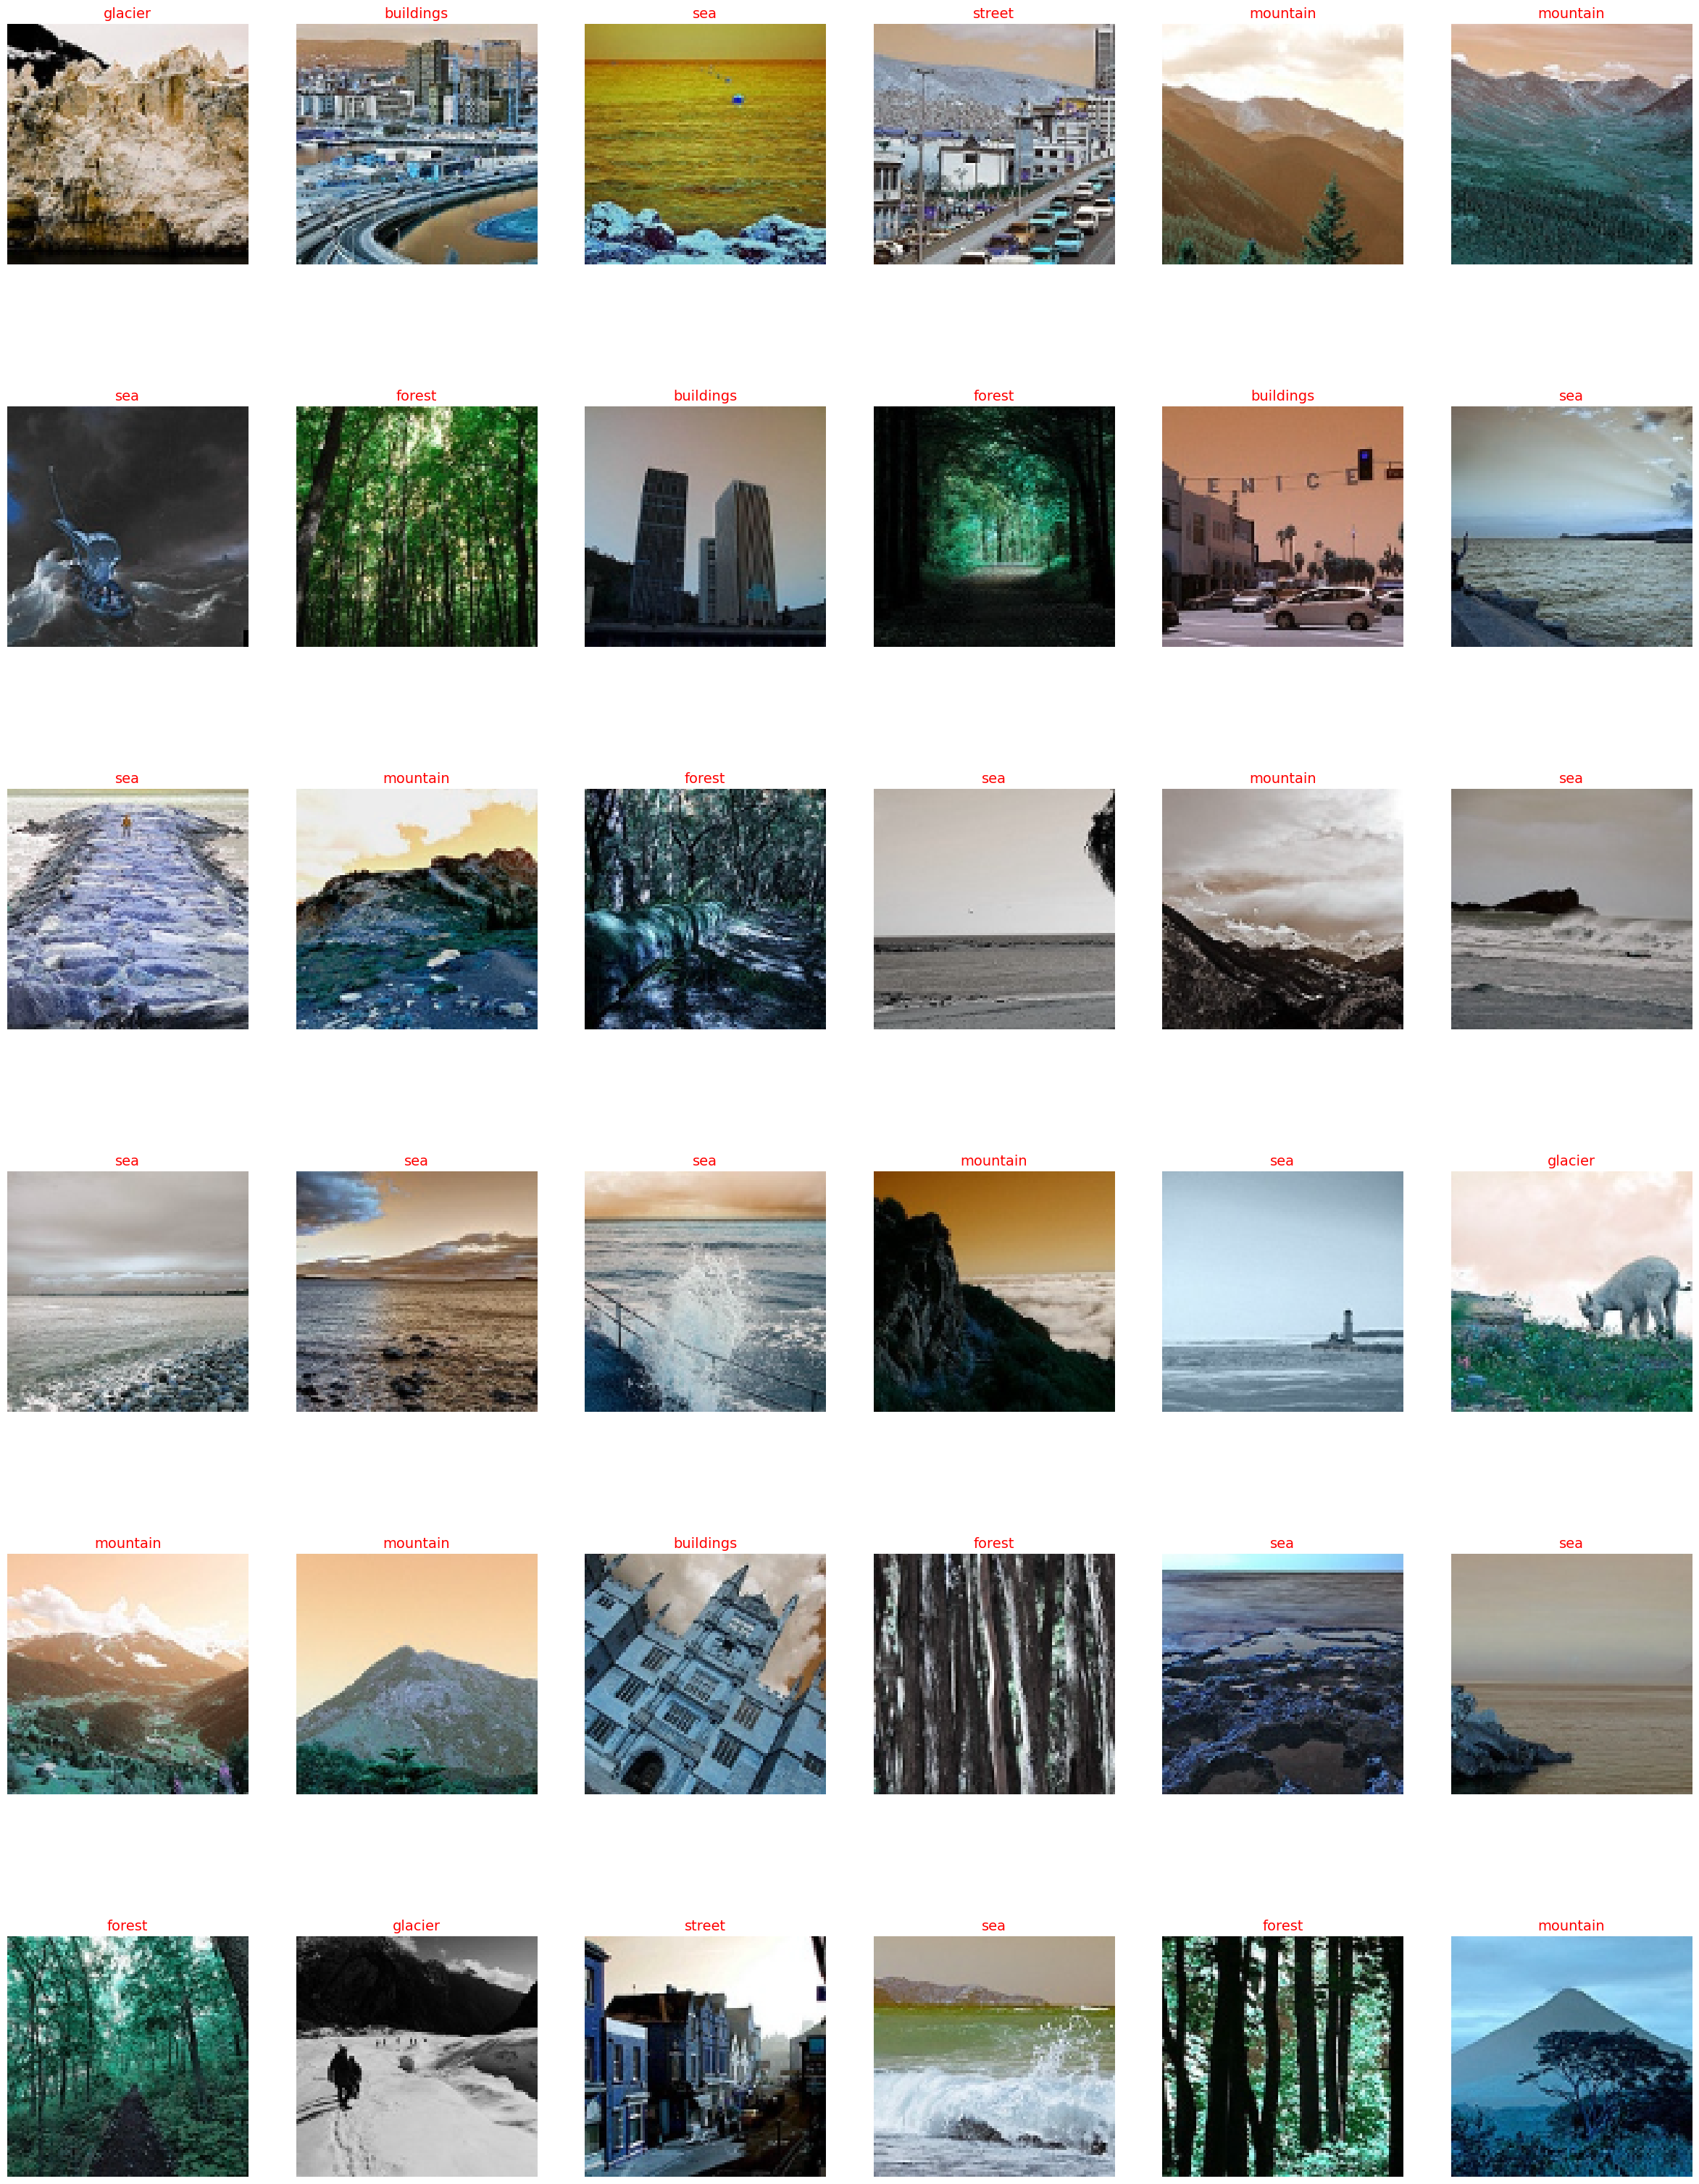

In [ ]:
plot_some_image(X_test, y_test, 'Test')

**Plotting Images from Prediction Dataset**

----------------------------------------------------------------------------- Prediction Data -----------------------------------------------------------------------------


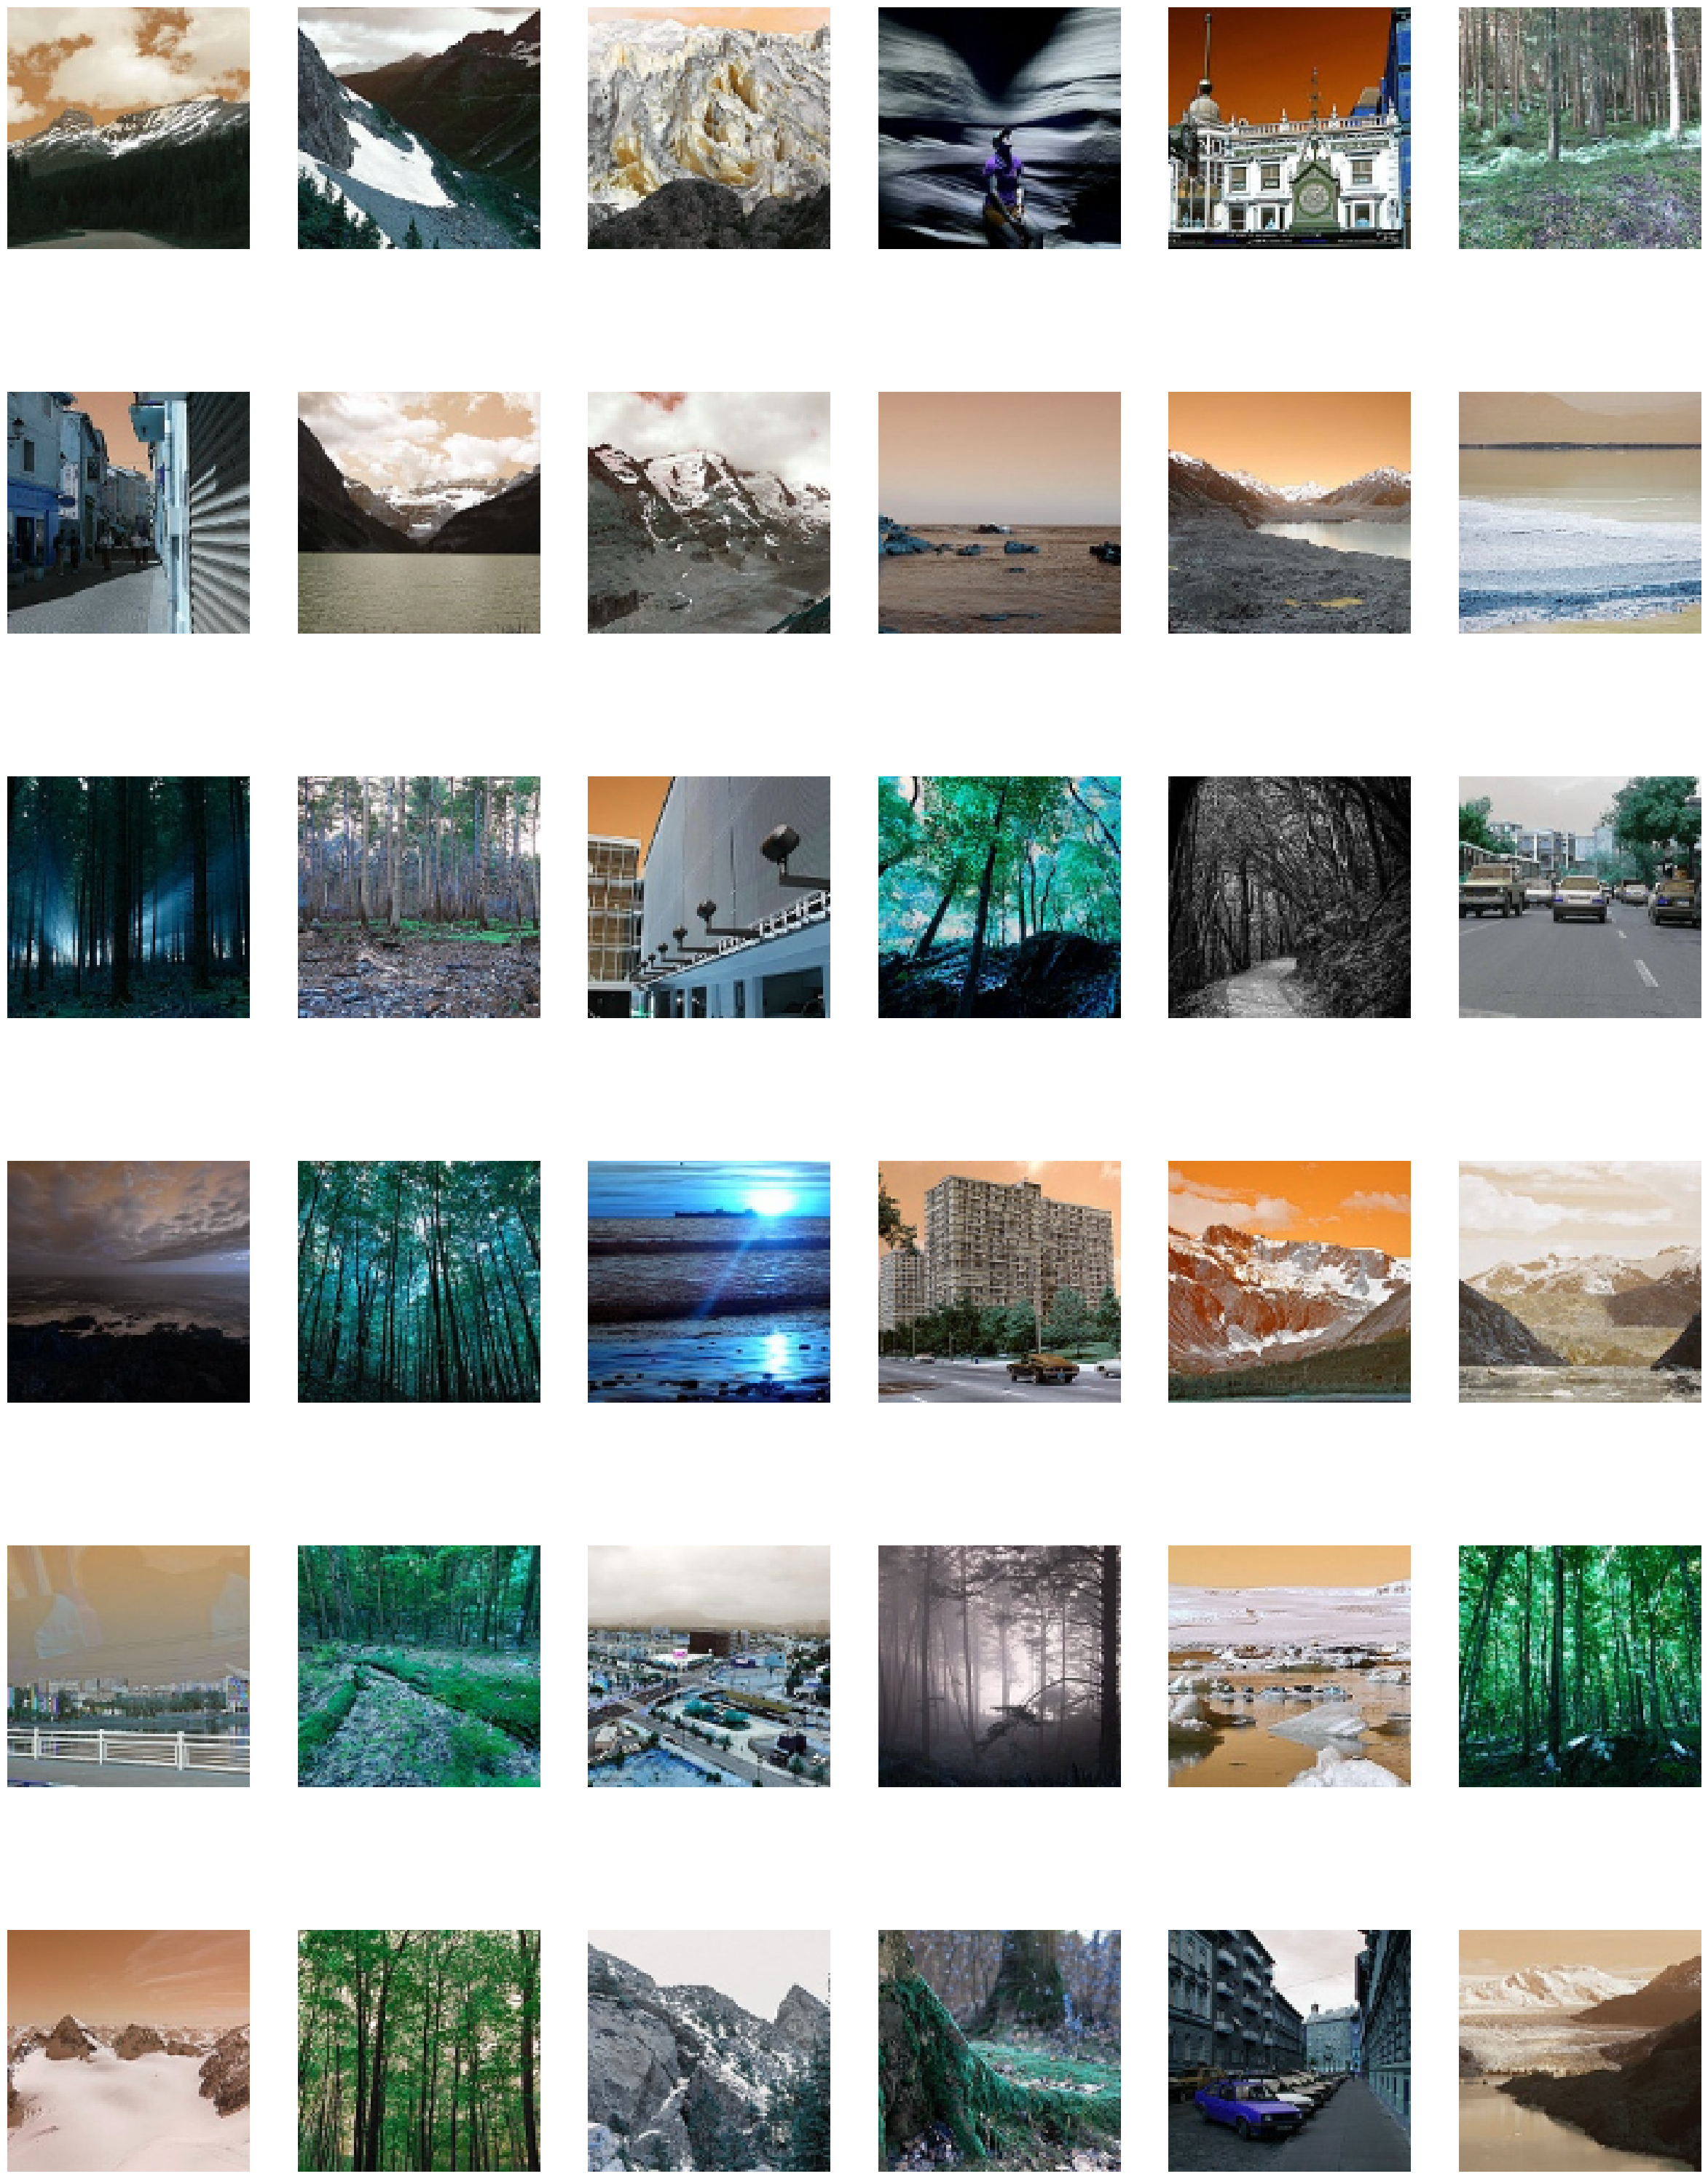

In [ ]:
plot_some_image(X_pred, None, 'Prediction')

In [ ]:
!pip install networkx scikit-image

In [ ]:
pip install torch torchvision torchaudio torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn


# Data Pre-Processing

****

**1.converting Images into segments using SLIC Segmentation**

In [ ]:
from skimage.segmentation import slic
from skimage.color import rgb2lab
import networkx as nx
import numpy as np

def compute_rag(image, segments):
    graph = nx.Graph()
    rows, cols = segments.shape
    for i in range(rows):
        for j in range(cols):
            current_segment = segments[i, j]
            for di, dj in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    neighbor_segment = segments[ni, nj]
                    if neighbor_segment != current_segment:
                        graph.add_edge(current_segment, neighbor_segment)
    lab_image = rgb2lab(image)
    for node in graph.nodes:
        mask = (segments == node)
        mean_color = np.mean(lab_image[mask], axis=0)
        graph.nodes[node]['feature'] = mean_color
    return graph

def image_to_graph(image, n_segments=500, sigma=1, compactness=10):
    segments = slic(image, n_segments=n_segments, sigma=sigma, compactness=compactness, start_label=0)
    graph = compute_rag(image, segments)
    return graph, segments


**2.Function to process an entire dataset of images**

In [ ]:
def process_dataset(images, n_segments=500, sigma=1, compactness=10):
    graphs = []
    segmentations = []

    for image in images:
        graph, segments = image_to_graph(np.array(image),
                                         n_segments=n_segments,
                                         sigma=sigma,
                                         compactness=compactness)
        graphs.append(graph)
        segmentations.append(segments)

    return graphs, segmentations

**Sample Image Segmentation**

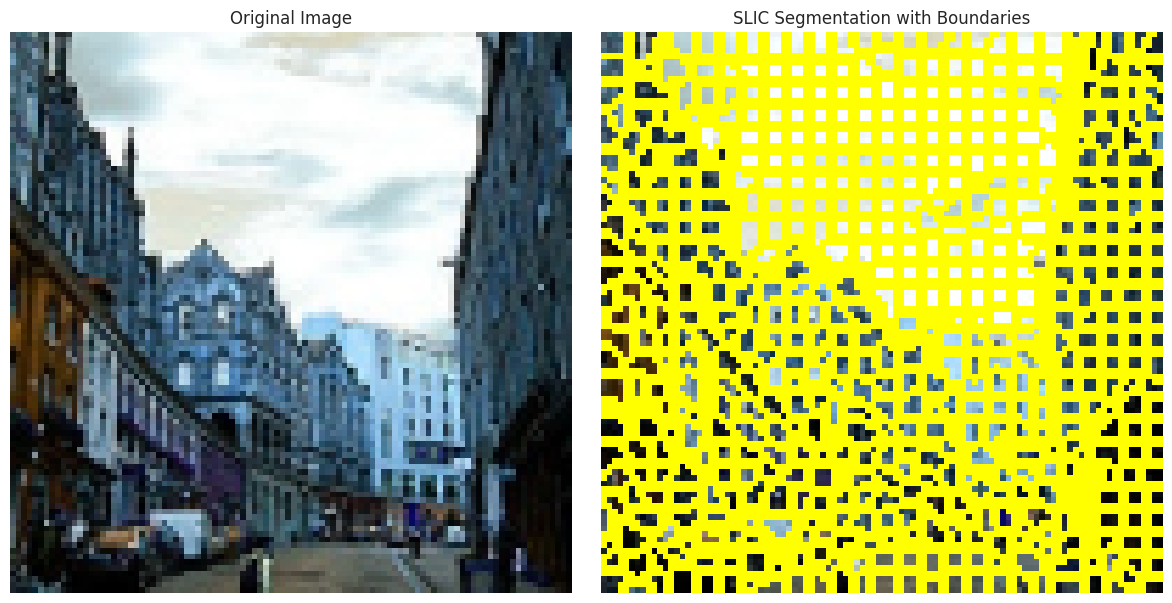

In [ ]:
from skimage.segmentation import mark_boundaries
def visualize_with_boundaries(original_image, segments):
    image_with_boundaries = mark_boundaries(original_image, segments, color=(1, 1, 0))  # Yellow boundaries
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(image_with_boundaries)
    axes[1].set_title("SLIC Segmentation with Boundaries")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
visualize_with_boundaries(original_image=np.array(X_train[0]), segments=segments)



**3.Adding segments in Training Data**

In [ ]:
print("Processing Training Data...")
train_graphs, train_segmentations = process_dataset(X_train,
                                                    n_segments=400,
                                                    sigma=1,
                                                    compactness=1)
print("processed training data")

Processing Training Data...
processed training data


**4.Adding segments in Testing Data**

In [ ]:
print("Processing Test Data...")
test_graphs, test_segmentations = process_dataset(X_test,
                                                  n_segments=400,
                                                  sigma=1,
                                                  compactness=1)
print("processed testing data")

Processing Test Data...
processed testing data


**5.Adding segments in Prediction Data**

In [27]:
print("Processing Prediction Data...")
pred_graphs, pred_segmentations = process_dataset(X_pred,
                                                  n_segments=400,
                                                  sigma=1,
                                                  compactness=1)
print("processed prediction data")

Processing Prediction Data...
processed prediction data


**6. Plotting Original vs Segmented image**

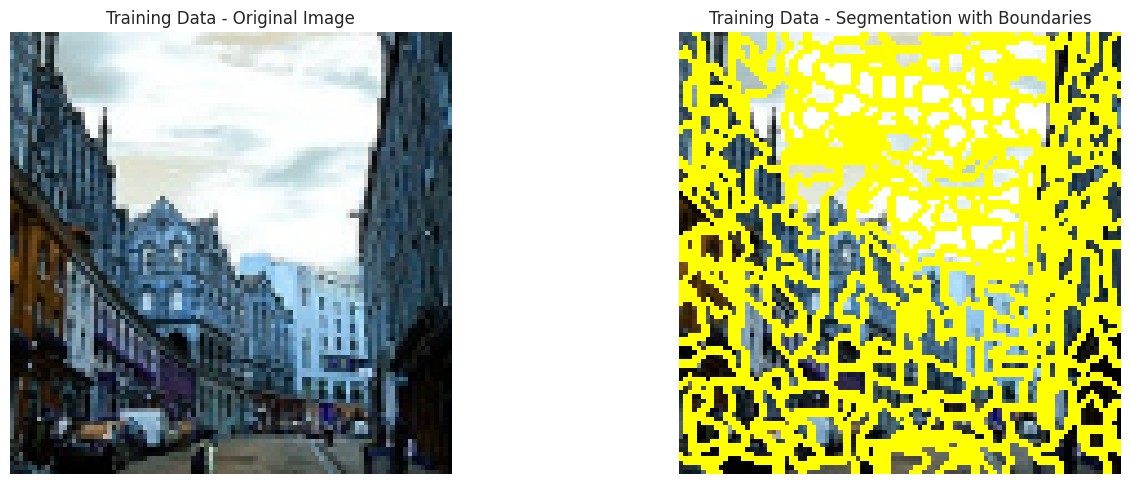

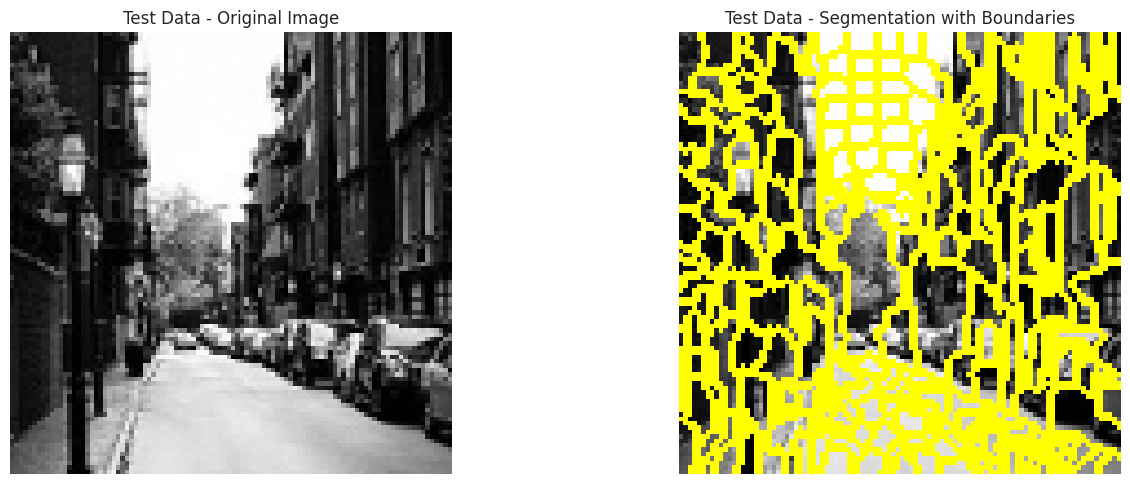

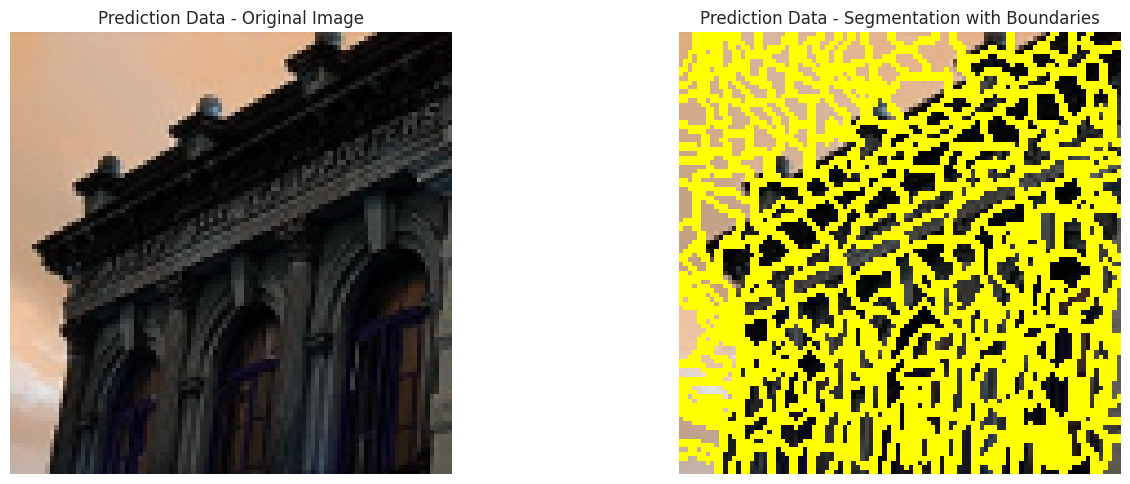

In [29]:
def visualize_dataset_with_boundaries(images, segmentations, title, num_examples=1):
    plt.figure(figsize=(15, 5 * num_examples))

    for i in range(num_examples):
        original_image = np.array(images[i])
        segmentation = np.array(segmentations[i])
        plt.subplot(num_examples, 2, i * 2 + 1)
        plt.imshow(original_image)
        plt.title(f"{title} - Original Image")
        plt.axis("off")
        plt.subplot(num_examples, 2, i * 2 + 2)
        slic_boundaries = mark_boundaries(original_image, segmentation, color=(1, 1, 0))  # Yellow boundaries
        plt.imshow(slic_boundaries)
        plt.title(f"{title} - Segmentation with Boundaries")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
visualize_dataset_with_boundaries(X_train, train_segmentations, "Training Data", num_examples=1)
visualize_dataset_with_boundaries(X_test, test_segmentations, "Test Data", num_examples=1)
visualize_dataset_with_boundaries(X_pred, pred_segmentations, "Prediction Data", num_examples=1)


**7. Installing torch-geometric libarary to convert this into graphs and exact fetures from the images**

In [30]:
!pip install torch torch-geometric scikit-image

**8.Extract_features Function to Extract features from each superpixel**

In [31]:
def extract_superpixel_features(image, segments):
    from skimage.measure import regionprops
    from skimage.color import rgb2gray

    grayscale_image = rgb2gray(image)
    features = []
    props = regionprops(segments, intensity_image=grayscale_image)

    for region in props:
        mask = (segments == region.label)
        mean_color = np.mean(image[mask], axis=0)
        eccentricity = region.eccentricity
        bbox = region.bbox
        aspect_ratio = (bbox[3] - bbox[1]) / (bbox[2] - bbox[0]) if (bbox[2] - bbox[0]) > 0 else 0
        solidity = region.solidity
        centroid = region.centroid
        perimeter = region.perimeter

        features.append([
            *mean_color, eccentricity, aspect_ratio, solidity, centroid[0], centroid[1], perimeter
        ])

    return np.array(features)


**9.Converting the Images into graphs**

In [32]:
def convert_rag_to_pytorch_graph(rag, features):
    import torch
    from torch_geometric.data import Data
    edge_index = torch.tensor(list(rag.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)


**10.Processing the graphs and Saving them into Train_graphs, Test_graphs and Pred_graphs**

In [33]:
def process_dataset_to_pytorch_graphs(images, segmentations, rags, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for idx, (image, segments, rag) in enumerate(zip(images, segmentations, rags)):
        features = extract_superpixel_features(np.array(image), segments)
        graph = convert_rag_to_pytorch_graph(rag, features)
        graph.y = torch.tensor([labels[idx]], dtype=torch.long)
        output_path = os.path.join(output_dir, f'graph_{idx}.pt')
        torch.save(graph, output_path)
    return len(images)

train_output_dir = "/content/train_graphs"
test_output_dir = "/content/test_graphs"
pred_output_dir = "/content/pred_graphs"

In [34]:
print("Processing and saving training dataset...")
num_train_graphs = process_dataset_to_pytorch_graphs(
    X_train, train_segmentations, train_graphs, y_train, train_output_dir
)
print(f"All {num_train_graphs} training graphs have been processed and saved to {train_output_dir}.")

Processing and saving training dataset...
All 14034 training graphs have been processed and saved to /content/train_graphs.


In [35]:
print("Processing and saving testing dataset...")
num_test_graphs = process_dataset_to_pytorch_graphs(
    X_test, test_segmentations, test_graphs, y_test, test_output_dir
)
print(f"All {num_test_graphs} testing graphs have been processed and saved to {test_output_dir}.")

Processing and saving testing dataset...
All 3000 testing graphs have been processed and saved to /content/test_graphs.


In [36]:
print("Processing and saving prediction dataset...")
num_pred_graphs = process_dataset_to_pytorch_graphs(
    X_pred, pred_segmentations, pred_graphs, [0] * len(X_pred), pred_output_dir
)
print(f"All {num_pred_graphs} prediction graphs have been processed and saved to {pred_output_dir}.")

Processing and saving prediction dataset...
All 7301 prediction graphs have been processed and saved to /content/pred_graphs.


**11.Checking the validation of the graphs**

In [37]:
print("Testing the validity of test_graphs...")
for idx, rag in enumerate(test_graphs[:5]):
    if not isinstance(rag, nx.Graph):
        raise ValueError(f"test_graphs[{idx}] is not a valid networkx graph.")
    print(f"test_graphs[{idx}] is valid.")

# Check pred_graphs
print("Testing the validity of pred_graphs...")
for idx, rag in enumerate(pred_graphs[:5]):
    if not isinstance(rag, nx.Graph):
        raise ValueError(f"pred_graphs[{idx}] is not a valid networkx graph.")
    print(f"pred_graphs[{idx}] is valid.")


Testing the validity of test_graphs...
test_graphs[0] is valid.
test_graphs[1] is valid.
test_graphs[2] is valid.
test_graphs[3] is valid.
test_graphs[4] is valid.
Testing the validity of pred_graphs...
pred_graphs[0] is valid.
pred_graphs[1] is valid.
pred_graphs[2] is valid.
pred_graphs[3] is valid.
pred_graphs[4] is valid.


**12.Printing Node Features**

In [38]:
def load_and_print_features(graph_dir, num_graphs=1):
    print(f"Extracting features from the first {num_graphs} graphs in {graph_dir}...")
    for idx in range(num_graphs):
        graph_path = f"{graph_dir}/graph_{idx}.pt"
        graph = torch.load(graph_path)
        print(f"\nGraph {idx}:")
        print(f"Node Features Shape: {graph.x.shape}")
        print(f"Node Features (First 5 Nodes):\n{graph.x[:5]}")
train_graph_dir = "/content/train_graphs"
test_graph_dir = "/content/test_graphs"
pred_graph_dir = "/content/pred_graphs"

print("Training Dataset:")
load_and_print_features(train_graph_dir, num_graphs=1)

print("\nTesting Dataset:")
load_and_print_features(test_graph_dir, num_graphs=1)

print("\nPrediction Dataset:")
load_and_print_features(pred_graph_dir, num_graphs=1)


Training Dataset:
Extracting features from the first 1 graphs in /content/train_graphs...

Graph 0:
Node Features Shape: torch.Size([242, 9])
Node Features (First 5 Nodes):
tensor([[ 95.3077, 109.8615, 112.2769,   0.7489,   0.7273,   0.9028,   4.1077,
           8.2000,  32.0355],
        [180.9048, 205.3333, 209.5238,   0.9560,   0.6667,   0.8077,   3.8571,
          14.6667,  18.8640],
        [187.4706, 213.0000, 218.1176,   0.7067,   0.8889,   0.7391,   2.4118,
          17.5000,  22.0355],
        [205.8108, 227.8108, 233.1892,   0.9206,   0.5455,   0.7708,   4.7568,
          21.3784,  26.2782],
        [230.0370, 242.1481, 244.7963,   0.9533,   0.4118,   0.6279,   6.5000,
          25.4444,  39.1421]])

Testing Dataset:
Extracting features from the first 1 graphs in /content/test_graphs...

Graph 0:
Node Features Shape: torch.Size([182, 9])
Node Features (First 5 Nodes):
tensor([[ 25.5538,  25.5538,  25.5538,   0.5969,   0.8000,   0.8784,   3.8923,
           8.6615,  31.2426],


<ipython-input-38-5669d2932a45>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(graph_path)


**Plotting node features**

<ipython-input-39-a03ff38c691a>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(graph_path)


Visualizing features of the first graph:


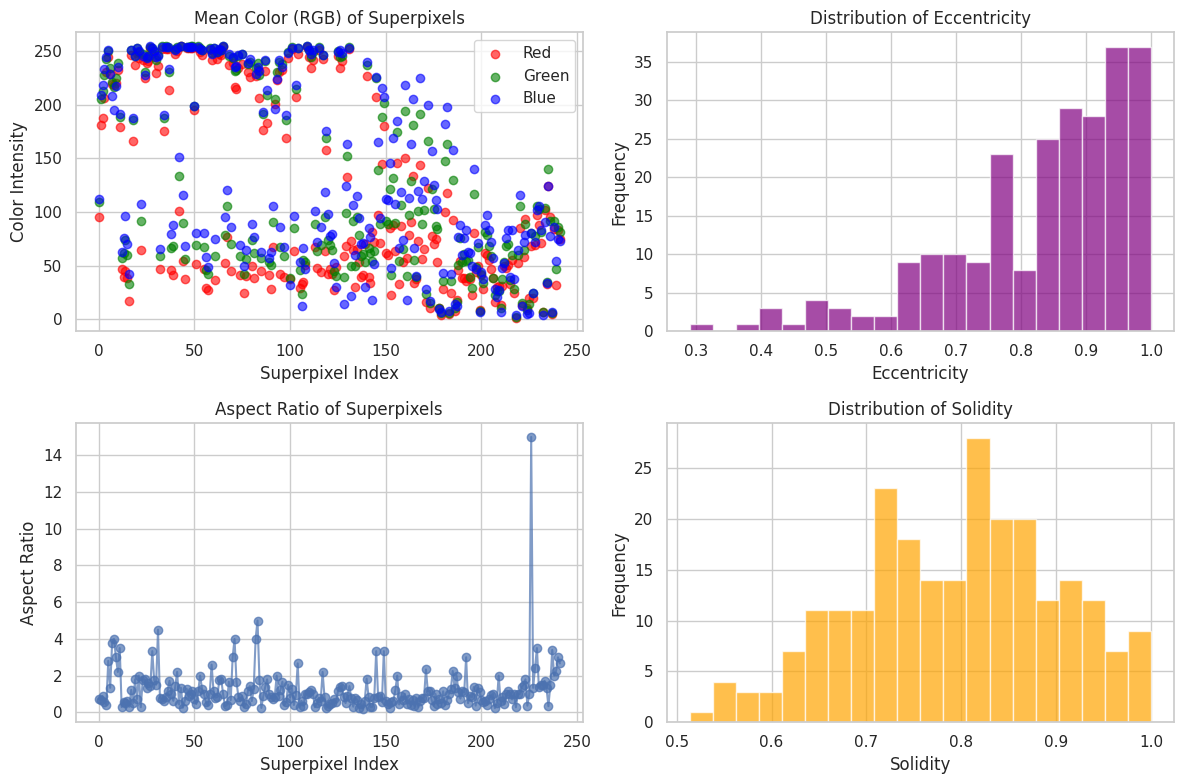

In [39]:
def load_graphs_from_dir(directory, num_graphs=5):
    graph_files = sorted(os.listdir(directory))[:num_graphs]
    graphs = []
    for file in graph_files:
        graph_path = os.path.join(directory, file)
        graph = torch.load(graph_path)
        graphs.append(graph)
    return graphs

def visualize_graph_features(graph):
    x = graph.x.numpy()
    R, G, B = x[:, 0], x[:, 1], x[:, 2]
    eccentricity = x[:, 3]
    aspect_ratio = x[:, 4]
    solidity = x[:, 5]
    centroid_y, centroid_x = x[:, 6], x[:, 7]
    perimeter = x[:, 8]
    plt.figure(figsize=(12, 8))

    # 1. Mean Color (RGB)
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(R)), R, color='red', label='Red', alpha=0.6)
    plt.scatter(range(len(G)), G, color='green', label='Green', alpha=0.6)
    plt.scatter(range(len(B)), B, color='blue', label='Blue', alpha=0.6)
    plt.title("Mean Color (RGB) of Superpixels")
    plt.xlabel("Superpixel Index")
    plt.ylabel("Color Intensity")
    plt.legend()

    # 2. Eccentricity
    plt.subplot(2, 2, 2)
    plt.hist(eccentricity, bins=20, color='purple', alpha=0.7)
    plt.title("Distribution of Eccentricity")
    plt.xlabel("Eccentricity")
    plt.ylabel("Frequency")

    # 3. Aspect Ratio
    plt.subplot(2, 2, 3)
    plt.plot(range(len(aspect_ratio)), aspect_ratio, marker='o', linestyle='-', alpha=0.7)
    plt.title("Aspect Ratio of Superpixels")
    plt.xlabel("Superpixel Index")
    plt.ylabel("Aspect Ratio")

    # 4. Solidity
    plt.subplot(2, 2, 4)
    plt.hist(solidity, bins=20, color='orange', alpha=0.7)
    plt.title("Distribution of Solidity")
    plt.xlabel("Solidity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Loading a few graphs for visualization
train_graphs_dir = "/content/train_graphs"
graphs = load_graphs_from_dir(train_graphs_dir, num_graphs=3)

# Visualize features of the first graph
print("Visualizing features of the first graph:")
visualize_graph_features(graphs[0])


#3. Model Implementation

**1. Importing Graph data**

In [40]:
import torch
import os
from torch_geometric.data import Data

def load_graphs_from_directory(directory, num_graphs=None):
    graph_files = sorted(os.listdir(directory))
    if num_graphs is not None:
        graph_files = graph_files[:num_graphs]

    graphs = []
    for file in graph_files:
        graph_path = os.path.join(directory, file)
        graph = torch.load(graph_path)
        graphs.append(graph)

    return graphs

# Directories for graphs
train_graph_dir = "/content/train_graphs"
test_graph_dir = "/content/test_graphs"
pred_graph_dir = "/content/pred_graphs"

# Load the graphs
train_graphs = load_graphs_from_directory(train_graph_dir)
test_graphs = load_graphs_from_directory(test_graph_dir)
pred_graphs = load_graphs_from_directory(pred_graph_dir)

# Print the number of graphs loaded
print(f"Loaded {len(train_graphs)} training graphs.")
print(f"Loaded {len(test_graphs)} testing graphs.")
print(f"Loaded {len(pred_graphs)} prediction graphs.")

<ipython-input-40-c0af115b1f14>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(graph_path)


Loaded 14034 training graphs.
Loaded 3000 testing graphs.
Loaded 7301 prediction graphs.


**2. Importing necessary libraries**

In [132]:
import torch
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


**3.GCN Model Implementation**

In [133]:
class UpdatedGCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.3):
        super(UpdatedGCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dims[0])  # First GCN layer
        self.batch_norm1 = BatchNorm(hidden_dims[0])
        self.conv2 = GCNConv(hidden_dims[0], hidden_dims[1])  # Second GCN layer
        self.batch_norm2 = BatchNorm(hidden_dims[1])
        self.conv3 = GCNConv(hidden_dims[1], hidden_dims[2])  # Third GCN layer
        self.batch_norm3 = BatchNorm(hidden_dims[2])
        self.fc1 = Linear(hidden_dims[2], hidden_dims[3])  # Fully connected layer
        self.fc2 = Linear(hidden_dims[3], num_classes)  # Final output layer
        self.relu = ReLU()
        self.dropout = Dropout(p=dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.relu(self.batch_norm1(self.conv1(x, edge_index)))
        x = self.relu(self.batch_norm2(self.conv2(x, edge_index)))
        x = self.relu(self.batch_norm3(self.conv3(x, edge_index)))
        x = global_mean_pool(x, batch)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


**4.Calculating class weights based on training data**

In [134]:
def compute_class_weights(dataset):
    class_counts = Counter([data.y.item() for data in dataset])
    class_weights = [1.0 / class_counts[i] for i in range(len(class_counts))]
    return torch.tensor(class_weights, dtype=torch.float)

class_weights = compute_class_weights(train_graphs)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


**5.Normalizing Node Features for Traing and Testing dataset**

In [135]:
def normalize_features(loader):
    all_features = torch.cat([data.x for data in loader.dataset], dim=0)
    mean = all_features.mean(dim=0)
    std = all_features.std(dim=0)

    for data in loader.dataset:
        data.x = (data.x - mean) / std
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

normalize_features(train_loader)
normalize_features(test_loader)


**6. Configuring Model Dimensions**

In [136]:
hidden_dims = [512, 256, 128, 64]
model = UpdatedGCNModel(input_dim=9, hidden_dims=hidden_dims, num_classes=6, dropout=0.3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


UpdatedGCNModel(
  (conv1): GCNConv(9, 512)
  (batch_norm1): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(512, 256)
  (batch_norm2): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(256, 128)
  (batch_norm3): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

**7.Training the model for 100 epochs**

In [138]:
epochs = 100
best_val_loss = float('inf')
patience = 10
no_improve_epochs = 0

for epoch in range(epochs):
    # Training loop
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step(total_loss)

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    y_test_pred = []
    y_test_actual = []
    val_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1).cpu().numpy()
            y_test_pred.extend(pred)
            y_test_actual.extend(data.y.cpu().numpy())
            correct += (pred == data.y.cpu().numpy()).sum()
            total += data.y.size(0)
            val_loss += criterion(out, data.y).item()
    accuracy = correct / total

    # Track validation loss
    val_loss /= len(test_loader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/100, Train Loss: 459.8756, Val Loss: 0.9240, Accuracy: 0.6507
Epoch 2/100, Train Loss: 436.9127, Val Loss: 0.8796, Accuracy: 0.6760
Epoch 3/100, Train Loss: 417.6014, Val Loss: 0.8986, Accuracy: 0.6717
Epoch 4/100, Train Loss: 408.3117, Val Loss: 0.9181, Accuracy: 0.6580
Epoch 5/100, Train Loss: 396.2669, Val Loss: 0.8300, Accuracy: 0.6917
Epoch 6/100, Train Loss: 385.9906, Val Loss: 0.7930, Accuracy: 0.7083
Epoch 7/100, Train Loss: 379.7254, Val Loss: 0.7778, Accuracy: 0.7173
Epoch 8/100, Train Loss: 373.4834, Val Loss: 0.8108, Accuracy: 0.7163
Epoch 9/100, Train Loss: 367.4650, Val Loss: 0.7655, Accuracy: 0.7257
Epoch 10/100, Train Loss: 363.2863, Val Loss: 0.7647, Accuracy: 0.7227
Epoch 11/100, Train Loss: 352.8159, Val Loss: 0.8126, Accuracy: 0.7050
Epoch 12/100, Train Loss: 352.6156, Val Loss: 0.8229, Accuracy: 0.7100
Epoch 13/100, Train Loss: 346.8025, Val Loss: 0.7541, Accuracy: 0.7270
Epoch 14/100, Train Loss: 342.6177, Val Loss: 0.7709, Accuracy: 0.7227
Epoch 15/100, T

#4.Results

**1.confusion matrix and classification report**

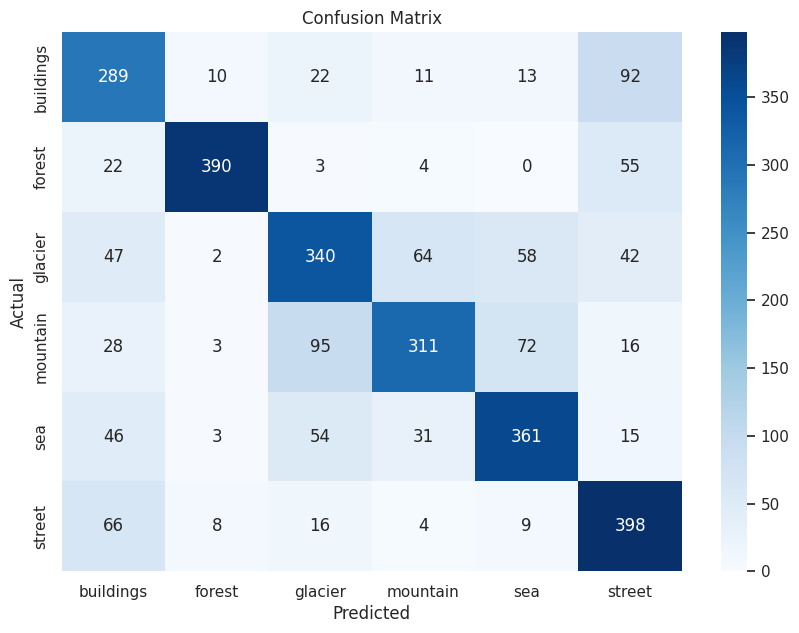

              precision    recall  f1-score   support

   buildings       0.58      0.66      0.62       437
      forest       0.94      0.82      0.88       474
     glacier       0.64      0.61      0.63       553
    mountain       0.73      0.59      0.65       525
         sea       0.70      0.71      0.71       510
      street       0.64      0.79      0.71       501

    accuracy                           0.70      3000
   macro avg       0.71      0.70      0.70      3000
weighted avg       0.71      0.70      0.70      3000



In [139]:
cm = confusion_matrix(y_test_actual, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=code.keys(), yticklabels=code.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_actual, y_test_pred, target_names=code.keys()))


In [82]:
model.eval()
y_test_pred = []

with torch.no_grad():
    for data in test_loader:
        data = data.to('cuda' if torch.cuda.is_available() else 'cpu')
        out = model(data)
        y_test_pred.append(out.cpu().numpy())
y_test_pred = np.vstack(y_test_pred)
print(f'Prediction Shape is {y_test_pred.shape}')


Prediction Shape is (3000, 6)


**2.Fetch actual and predicted labels**

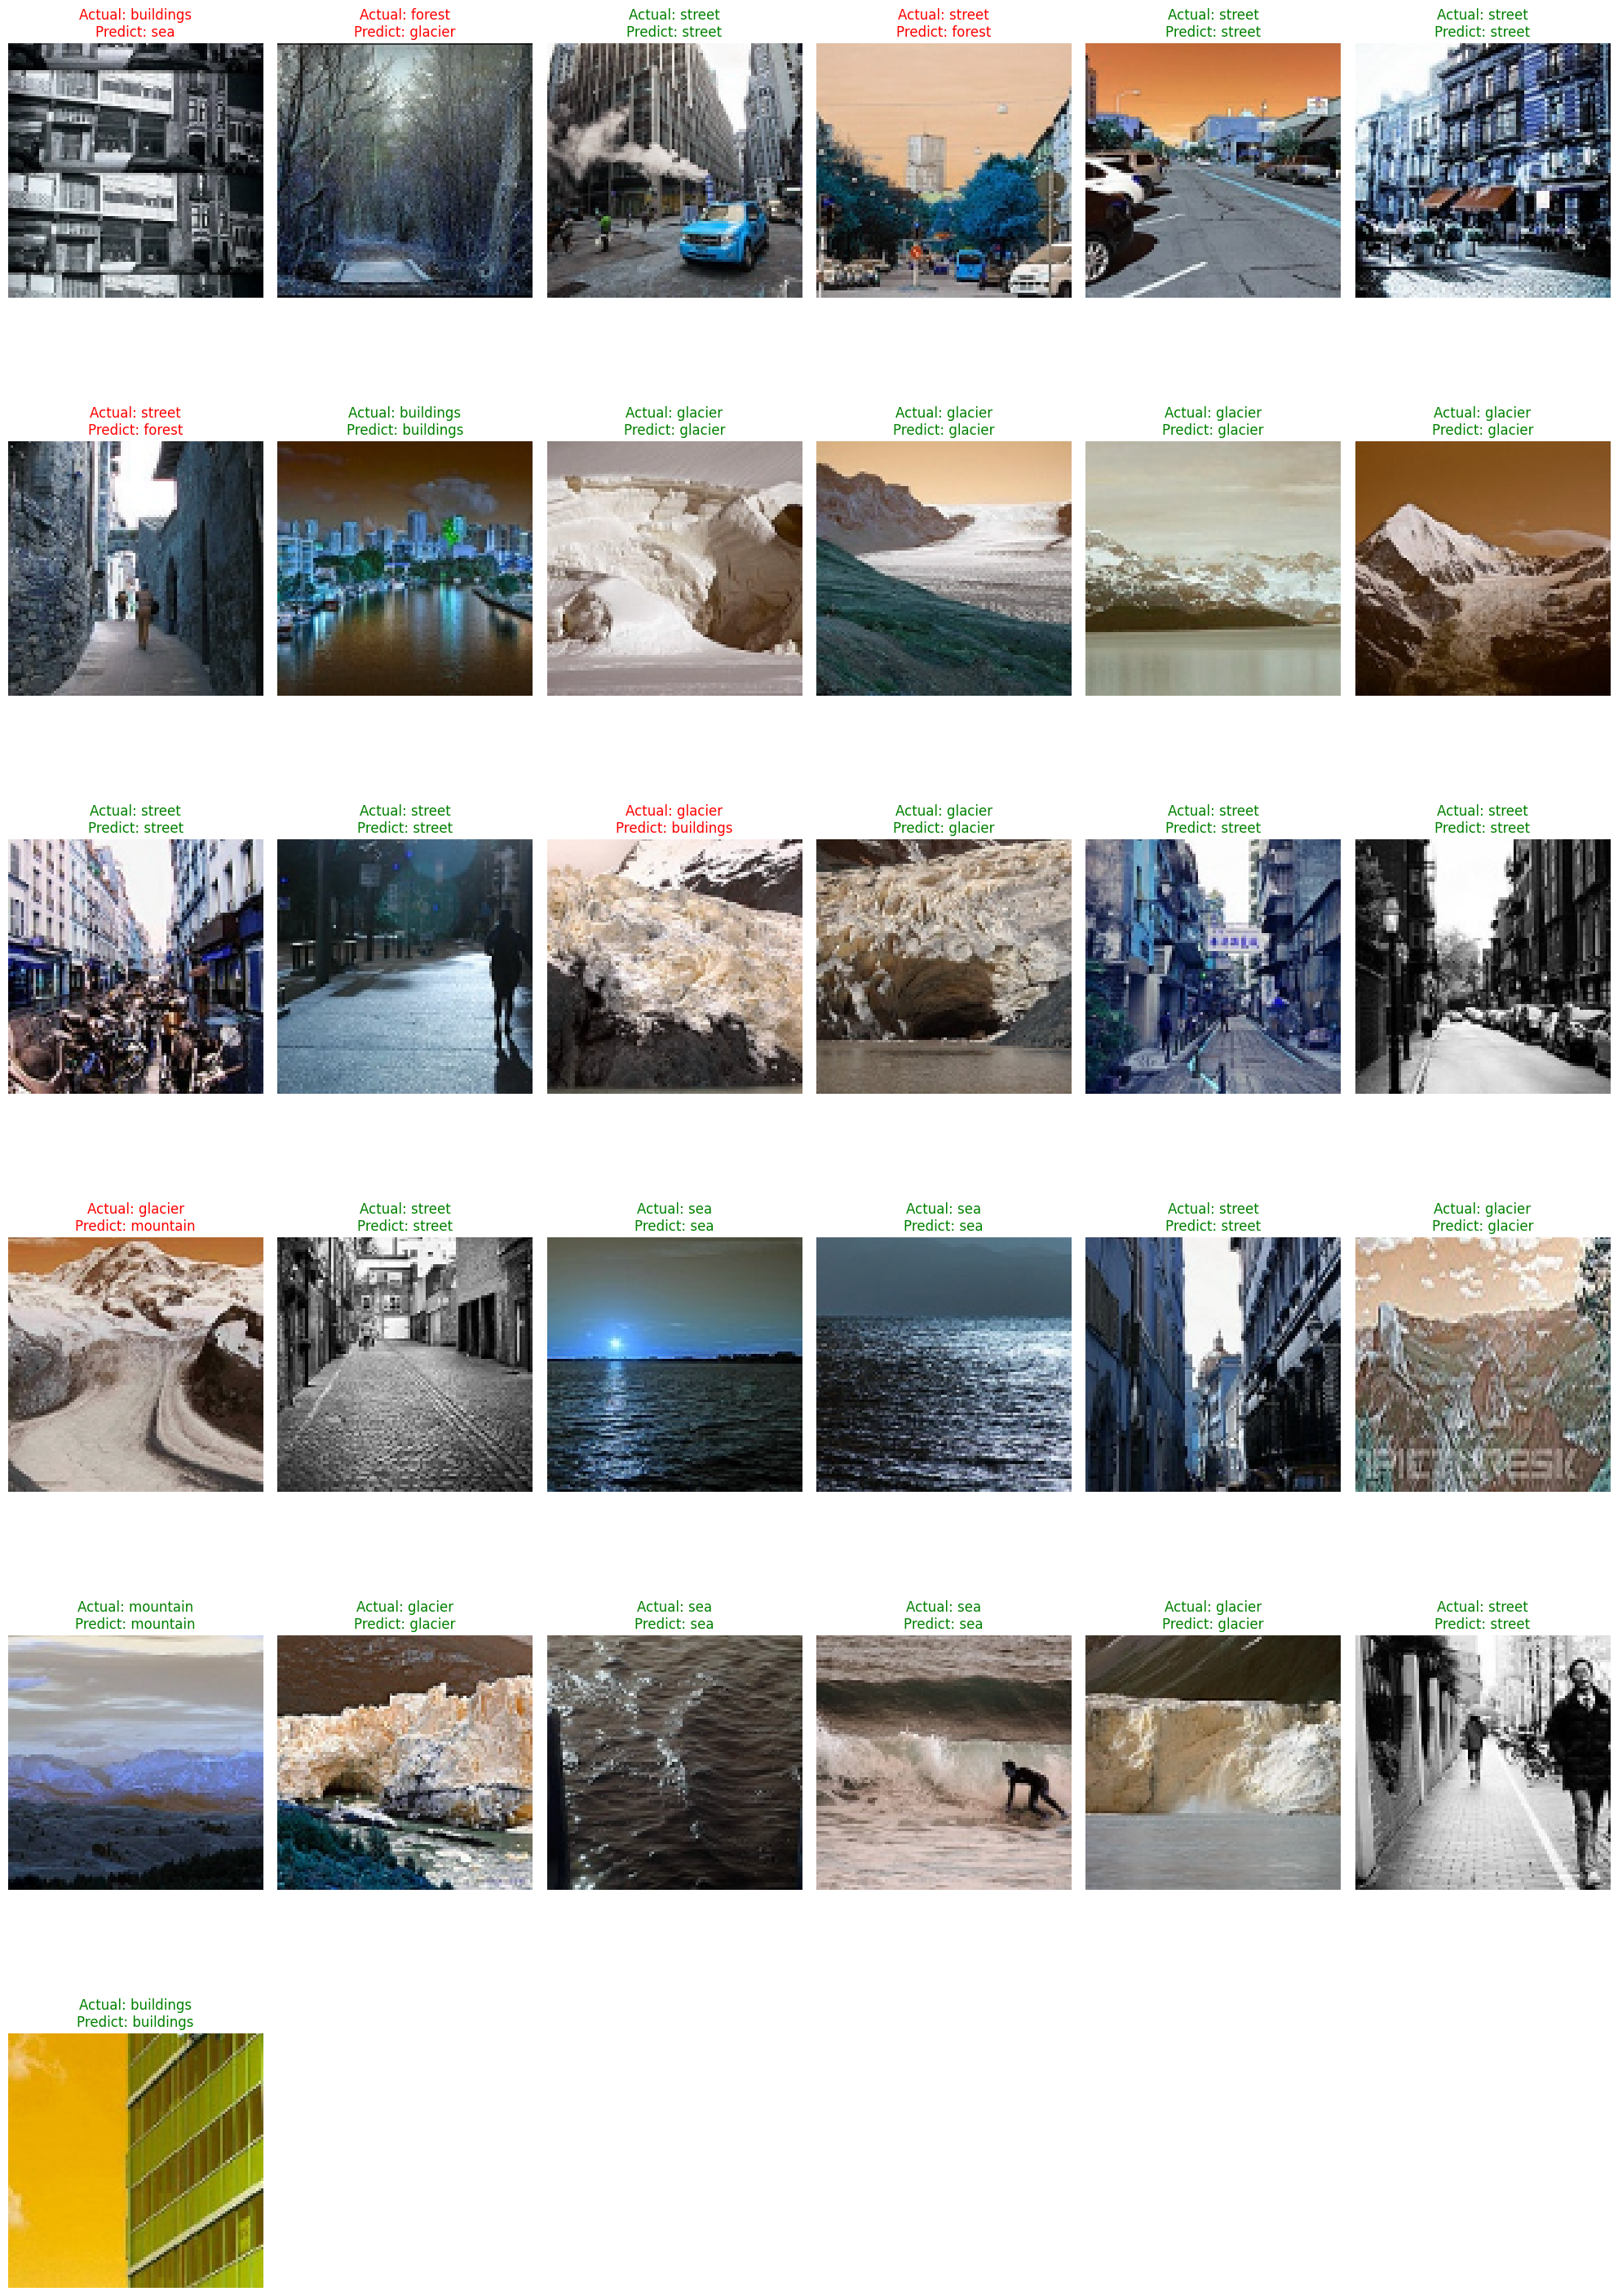

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import random

plt.figure(figsize=(30, 40))
random_indices = np.random.randint(0, len(X_test), 36)

for n, idx in enumerate(random_indices):
    plt.subplot(6, 6, n + 1)
    img = np.array(X_test[idx])
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis('off')

    # Fetch actual and predicted labels

    actual_label = get_name(y_test[idx])
    predicted_label = get_name(torch.argmax(y_test_pred[idx]).item())
    title_color = 'green' if actual_label == predicted_label else 'red
    plt.title(f"Actual: {actual_label}\nPredict: {predicted_label}", fontdict={'fontsize': 14, 'color': 'green'})

plt.tight_layout()
plt.show()

